In [806]:
import numpy as np
from numpy.linalg import inv
import timeit
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns

In [807]:
sns.set(rc={'figure.figsize': (14, 8.27)}, font_scale=2)
sns.set_palette('colorblind')

$min_x$$||Ax-b||_2^2 + lambda||x||_1$

# A)

$min_x$$ ||Ax-b||_2^2 + lambda||x||_1 $

$min_x$$||x||_1 = min_x \sum_{i=1}^n |  x_i |$
$min_x$$||x||_1 = min_x \sum_{i=1}^n min_{u_i}( -u_i \leq x_i \leq u_i)$

combining with the ll2 norm term, we get $min_{x,u_i} ||Ax-b||_2^2 + lambda \sum_{i=1}^n u_i$
sunbject to $-u_i \leq x_i \leq u_i$ for $i=1,...,n$
To enforce this we use the barrier function $-\sum_{i=1}^n log(u_i-x_i) + log(u_i+x_i) = -\sum_{i=1}^n log(u_i^2-x_i^2)$

Finally, we minimise $t\sum_i^m \left( \sum_j^n a_{ij} x_j - b_i \right) ^2 + t lambda -\sum_{j=1}^n log(u_j-x_j) + log(u_j+x_j) $

$$ \tilde{x} =
\left(\begin{array}{cc}
x \\
u
\end{array}\right)
$$

In [808]:
def f(A, b, x_til, lam, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    if (u-x < 0).any() or (u+x < 0).any():
        return 'infeasible'
    residual = A @ x - b
    return t*residual.T @ residual + t*lam*np.sum(u) - np.sum(np.log(u-x) + np.log(u+x))

# B)

## Gradient

$\frac{\partial f}{\partial x_k}$$ = 2 t \sum_i^m  \sum_j^n ( a_{ij} x_j - b_i ) a_{ik} + \frac{1}{u_k-x_k} - \frac{1}{u_k+x_k}$

In [809]:
def grad_f_x(A, b, x_til, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = 2*t*(A.T @ A @ x - A.T @ b) + 1/(u - x) - 1/(u + x)
    return gradient

$\frac{\partial f}{\partial u_k}$$ = tlambda - \frac{1}{u_k-x_k} - \frac{1}{u_k+x_k}$

In [810]:
def grad_f_u(x_til, t, lam):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = t*lam - 1/(u - x) - 1/(u + x)
    return gradient

In [811]:
def grad_f(A, b, x_til, t, lam):
    return np.concatenate((grad_f_x(A, b, x_til, t), grad_f_u(x_til, t, lam)))

## Hessian

$H_{11}$$ = \frac{\partial^2 f}{\partial x^2} = 2tA^TA + diag \left( \frac{1}{u_k+x_k} + \frac{1}{u_k-x_k}, .... \right)$

In [812]:
def grad_f_xx(A, x_til, t):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = 2*t*A.T @ A + np.diag(1/np.square(u + x) + 1/np.square(u - x))
    return gradient

$H_{12}$$ = $$H_{21}$$ = \frac{\partial^2 f}{\partial x \partial u} = diag \left( \frac{1}{u_k+x_k} - \frac{1}{u_k-x_k}, .... \right)$

In [813]:
def grad_f_xu(x_til):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = np.diag(1/np.square(u + x) - 1/np.square(u - x))
    return gradient

$H_{22}$$ = \frac{\partial^2 f}{\partial u^2} = diag \left( \frac{1}{u_k+x_k} + \frac{1}{u_k-x_k}, .... \right)$

In [814]:
def grad_f_uu(x_til):
    n =256
    x, u = x_til[:n], x_til[n:]
    gradient = np.diag(1/np.square(u + x) + 1/np.square(u - x))
    return gradient

$$ \tilde{H} =
\left(\begin{array}{cc}
H_{11} & H_{12}\\
H_{21} & H_{22}
\end{array}\right)
$$

In [815]:
def hessian_f(A, x_til, t):
    h_11 = grad_f_xx(A, x_til, t)
    h_12 = grad_f_xu(x_til)
    h_22 = grad_f_uu(x_til)
    return np.block([[h_11, h_12],[h_12, h_22]])

# C)

In [816]:
A = np.genfromtxt('2023-data/A.csv', delimiter=",")
x_0 = np.genfromtxt('2023-data/x.csv', delimiter=",")

In [817]:
b = A @ x_0 + np.random.uniform(-0.005, 0.005, A.shape[0])

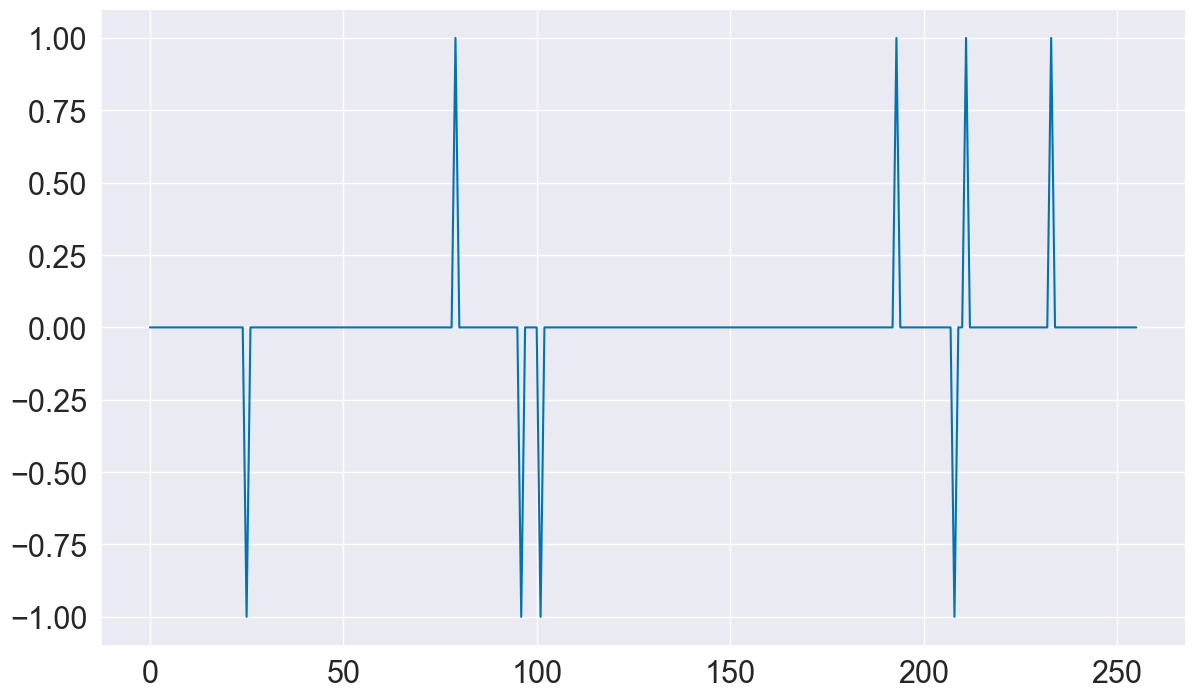

In [818]:
plt.plot(x_0)
plt.show()

In [819]:
def N_decrement(A, b, x_til, t, lam):
    jacobian = grad_f(A, b, x_til, t, lam)
    return (jacobian.T @ np.linalg.inv(hessian_f(A, x_til, t)) @ jacobian)/2

In [820]:
def Newtons_method(x_til_start, epsilon, t, lam_factor):
    lam_max = np.linalg.norm(2 * A.T @ b, ord=np.inf)
    lam = lam_factor * lam_max
    beta = 0.8
    iterations = 0
    x_til = x_til_start
    func = f(A, b, x_til, lam, t)
    costs = [func]
    grad = grad_f(A, b, x_til, t, lam)
    hessian = hessian_f(A, x_til, t)
    step = - np.linalg.inv(hessian) @ grad

    print(f't: {t}, Iteration: {iterations}, func: {func}')

    while (grad.T @ - step)/2 >= epsilon:
        t_b = 1
        while f(A, b, x_til + t_b * step, lam, t) == 'infeasible':
            t_b = t_b * beta
        x_til = x_til + t_b * step
        iterations += 1
        grad = grad_f(A, b, x_til, t, lam)
        hessian = hessian_f(A, x_til, t)
        step = - np.linalg.inv(hessian) @ grad
        func = f(A, b, x_til, lam, t)
        costs.append(func)
        print(f't: {t}, Iteration: {iterations}, func: {func}')
    return x_til, costs

In [821]:
x_til = np.concatenate((np.zeros(256), np.ones(256)))
ep = 0.1
for lam_factor in [0.01]:
    costs = []
    for t in [1, 10, 100, 1000]:
        x_til, cost = Newtons_method(x_til, ep, t, lam_factor)
        costs = costs + cost

t: 1, Iteration: 0, func: 899.3329943390866
t: 1, Iteration: 1, func: 461.63235416290877
t: 10, Iteration: 0, func: 5026.845791506924
t: 10, Iteration: 1, func: 1949.497817785893
t: 10, Iteration: 2, func: 1742.1734588060353
t: 10, Iteration: 3, func: 1726.328613142031
t: 10, Iteration: 4, func: 1725.1313304233634
t: 100, Iteration: 0, func: 7425.109897401404
t: 100, Iteration: 1, func: 4447.564441569792
t: 100, Iteration: 2, func: 4179.747047941733
t: 100, Iteration: 3, func: 4165.045601420981
t: 100, Iteration: 4, func: 4163.114229002621
t: 1000, Iteration: 0, func: 21528.432424230097
t: 1000, Iteration: 1, func: 18443.279751507092
t: 1000, Iteration: 2, func: 18220.44520222779
t: 1000, Iteration: 3, func: 18204.227913873412
t: 1000, Iteration: 4, func: 18202.568437123606
t: 1000, Iteration: 5, func: 18202.34911799125


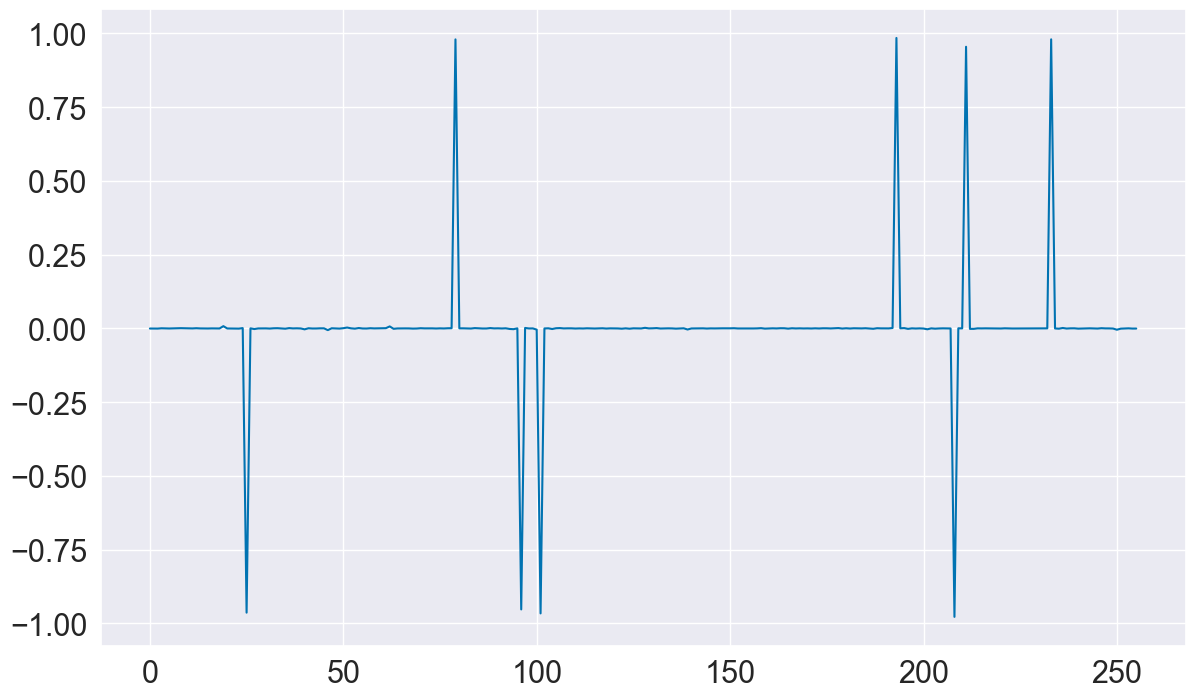

In [822]:
plt.plot(x_til_opt[:256])
plt.show()

# D)

In [826]:
x_til_opt = np.concatenate((np.zeros(256), np.ones(256)))
ep = 0.1
x_opt = []
for lam_factor in [10, 1, 0.5, 0.1, 0.05,  0.01, 0.005]:
    for t in [1, 10]:
        x_til_opt, cost = Newtons_method(x_til_opt, ep, t, lam_factor)
    x_opt.append(x_til_opt[:256])

t: 1, Iteration: 0, func: 463050.2148157332
t: 1, Iteration: 1, func: 50697.84064863909
t: 1, Iteration: 2, func: 8759.54193340096
t: 1, Iteration: 3, func: 4884.196344191253
t: 1, Iteration: 4, func: 4435.644252127075
t: 1, Iteration: 5, func: 4433.461981013952
t: 10, Iteration: 0, func: 12929.921356889925
t: 10, Iteration: 1, func: 9699.2252940224
t: 10, Iteration: 2, func: 9587.559288593426
t: 10, Iteration: 3, func: 9548.480887936406
t: 10, Iteration: 4, func: 9542.946396927438
t: 10, Iteration: 5, func: 9542.798797000476
t: 1, Iteration: 0, func: 5105.70116967357
t: 1, Iteration: 1, func: 4758.396281649717
t: 1, Iteration: 2, func: 4418.507366877793
t: 1, Iteration: 3, func: 4092.954703826011
t: 1, Iteration: 4, func: 3794.197153003733
t: 1, Iteration: 5, func: 3542.291715133395
t: 1, Iteration: 6, func: 3362.316975327852
t: 1, Iteration: 7, func: 3268.5736169914862
t: 1, Iteration: 8, func: 3240.906699844086
t: 1, Iteration: 9, func: 3237.353509945937
t: 1, Iteration: 10, func: 3

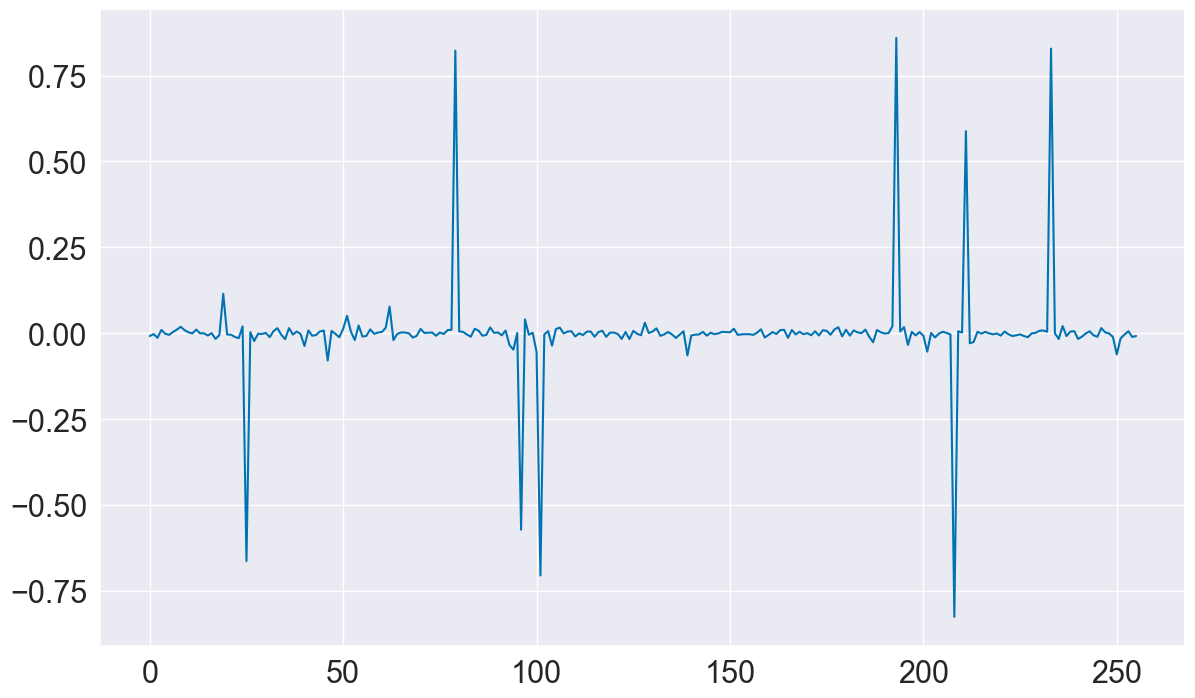

In [831]:
plt.plot(x_opt[4])
plt.show()